In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import dataset as dd # custom dataset class
import models as md

# so that when you change an imported file, it changes in the notebook
%load_ext autoreload 
%autoreload 2
%matplotlib notebook

/home/pkllee/anaconda2/envs/tf/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
do_channel_augmentation = False
epochs_to_train = 100

# use this to train on multiple datasets with data augmentation
#generator_train =  dd.MRImageSequence(scan_numbers=[1, 2, 3, 4], batch_size=10, augment_channels=do_channel_augmentation, augment_images=True)

# use this to train on a single knee (makai)
generator_train =  dd.MRImageSequence(scan_numbers=[1], batch_size=10, augment_channels=do_channel_augmentation)

generator_test = dd.MRImageSequence(scan_numbers=[5], batch_size=10, augment_channels=do_channel_augmentation)

('loading scan ', 1)
('X shape: ', (320, 320, 256, 8))
('y shape: ', (320, 320, 256, 1))
('augment_images: ', False)
('loading scan ', 5)
('X shape: ', (320, 320, 256, 8))
('y shape: ', (320, 320, 256, 1))
('augment_images: ', False)


In [3]:
input_shape = generator_train.x_transformed[0].shape[1:]
inputs = tf.keras.layers.Input(shape=input_shape)

#out = md.get_very_small_unet(inputs, use_pool=True)
out = md.get_unet(inputs, [(2, 32), (3, 64)], use_pool=True)

model = tf.keras.models.Model(inputs=inputs, outputs=out)


get_unet
('use_pool: ', True)
('gen_fn: ', 'gen_conv_relu')
('unet_shape: ', [(2, 32), (3, 64)])


In [4]:
## example from https://keras.io/callbacks/
class LossHistory(tf.keras.callbacks.Callback):
    
    def __init__(self, test_data = None):
        self.test_data = test_data
    
    def on_train_begin(self, logs={}):
        self.train_losses_batch = []
        self.train_losses_epoch = []
        self.test_losses = []

    def on_batch_end(self, batch, logs={}):
        self.train_losses_batch.append(logs.get('loss'))
        
    def on_epoch_end(self, epochs, logs={}):
        self.train_losses_epoch.append(logs.get('loss'))
        
        if (epochs % 10 == 0 and self.test_data != None):
            x, y = self.test_data
            loss, _ = self.model.evaluate(x, y, verbose=0)
            self.test_losses.append(loss)
            
        
        

history_callback = LossHistory(test_data=(generator_test.x_transformed[0], generator_test.y_transformed[0]))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/pkllee/tmp/')

adam_optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=0.01)

model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['mse'])

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 256, 8)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 256, 32) 2336        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 320, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 256, 32) 9248        activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [6]:
model.fit_generator(generator_train, callbacks=[history_callback, tb_callback], epochs=epochs_to_train, 
                    use_multiprocessing=False) # use_multiprocessing=True is slower by about 50% compared to model.fit() so set it to False

Epoch 1/100
32/32 [==============================] - 20s 627ms/step - loss: 3.8394e-04 - mean_squared_error: 3.8394e-04
Epoch 2/100
32/32 [==============================] - 9s 286ms/step - loss: 1.4949e-04 - mean_squared_error: 1.4949e-04
Epoch 3/100
32/32 [==============================] - 9s 276ms/step - loss: 1.3488e-04 - mean_squared_error: 1.3488e-04
Epoch 4/100
32/32 [==============================] - 8s 241ms/step - loss: 1.1820e-04 - mean_squared_error: 1.1820e-04
Epoch 5/100
32/32 [==============================] - 8s 265ms/step - loss: 1.0128e-04 - mean_squared_error: 1.0128e-04
Epoch 6/100
32/32 [==============================] - 9s 283ms/step - loss: 1.0406e-04 - mean_squared_error: 1.0406e-04
Epoch 7/100
32/32 [==============================] - 9s 274ms/step - loss: 8.4783e-05 - mean_squared_error: 8.4783e-05
Epoch 8/100
32/32 [==============================] - 9s 288ms/step - loss: 7.8033e-05 - mean_squared_error: 7.8033e-05
Epoch 9/100
32/32 [============================

32/32 [==============================] - 8s 262ms/step - loss: 3.7160e-05 - mean_squared_error: 3.7160e-05
Epoch 70/100
32/32 [==============================] - 8s 256ms/step - loss: 3.6895e-05 - mean_squared_error: 3.6895e-05
Epoch 71/100
32/32 [==============================] - 14s 445ms/step - loss: 3.7171e-05 - mean_squared_error: 3.7171e-05
Epoch 72/100
32/32 [==============================] - 8s 255ms/step - loss: 3.7046e-05 - mean_squared_error: 3.7046e-05
Epoch 73/100
32/32 [==============================] - 8s 263ms/step - loss: 3.6316e-05 - mean_squared_error: 3.6316e-05
Epoch 74/100
32/32 [==============================] - 8s 259ms/step - loss: 3.6286e-05 - mean_squared_error: 3.6286e-05
Epoch 75/100
32/32 [==============================] - 8s 258ms/step - loss: 3.6091e-05 - mean_squared_error: 3.6091e-05
Epoch 76/100
32/32 [==============================] - 8s 255ms/step - loss: 3.5959e-05 - mean_squared_error: 3.5959e-05
Epoch 77/100
32/32 [==============================] 

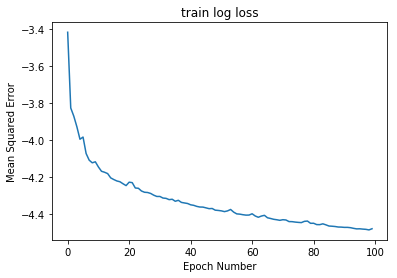

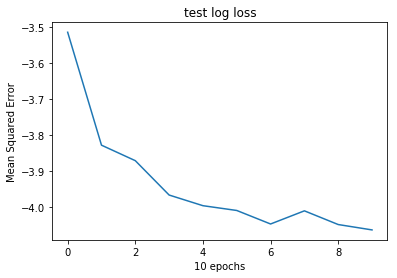

In [7]:
plt.plot(np.log10(history_callback.train_losses_epoch))
plt.title('train log loss')
plt.xlabel('Epoch Number')
plt.ylabel('Mean Squared Error')
plt.show()

plt.plot(np.log10(history_callback.test_losses))
plt.title('test log loss')
plt.xlabel('10 epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [8]:
pred_test = model.predict(generator_test.x_transformed[0])
to_show_ref_test = generator_test.y_transformed[0]
to_show_us_test = generator_test.x_transformed[0]

pred_train = model.predict(generator_train.x_transformed[0])
to_show_ref_train  = generator_train.y_transformed[0]
to_show_us_train = generator_train.x_transformed[0]


In [9]:
def show_images(slice_to_show, pred, ref, us):
    im1 = pred[slice_to_show, :, :, 0]    
    im2 = ref[slice_to_show, :, :, 0]
    im3 = dd.sos(us[slice_to_show, :, :, :], axis=2)

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(np.hstack((im1, im2, im3)), cmap='gray')
    plt.title('pred | ref | us')
    plt.axis('off')
    plt.show()

    fig = plt.figure(figsize=(5, 5))
    plt.imshow(abs(im2 - im1)* 10, cmap='gray', vmin=0, vmax=1)
    plt.title('diff x10')
    plt.axis('off')
    plt.show()

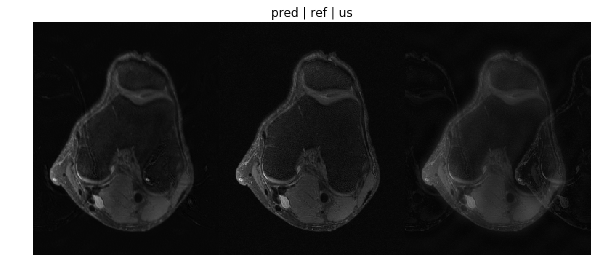

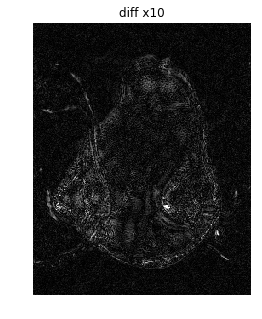

In [10]:
slice_to_show = 160
show_images(slice_to_show, pred_test, to_show_ref_test, to_show_us_test)

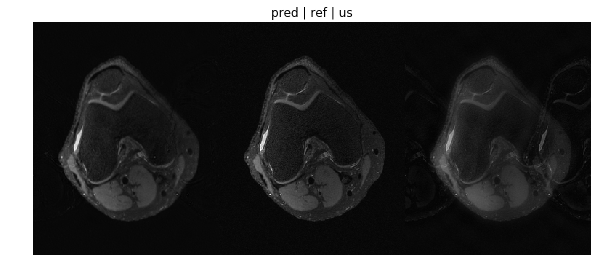

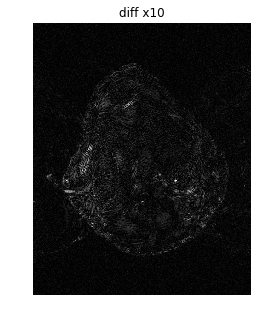

In [11]:
show_images(slice_to_show, pred_train, to_show_ref_train, to_show_us_train)

In [12]:
#model.save('models/very_small_unet_no_aug_kernel_1_3_no_pooling.h5')